In [ ]:
# En caso de problemas, utilizar las dependencias de librerías de este requierement: https://github.com/googlecolab/backend-info/blob/d6d345cb94fc5fd49951c9af0f6ead5e962bfab2/pip-freeze.txt
!pip install numpy==1.23.5
!pip install transformers[torch]==4.35.2
!pip install accelerate -U
!pip install evaluate

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 5

In [ ]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

**En este ejercicio debeis entrenar un modelo de clasificación utilizando la librería Transformers.** Dado que el análisis exploratorio ha sido realizado en el ejercicio anterior, en este caso podréis centraros en entrenar el modelo utilizando la librería Transformers, seleccionando un modelo pre-entrenado adecuado, entrenando el modelo y llevando a cabo la evaluación.


**Nota 1**: Este ejercicio requiere el uso de las GPUs de Google Colab. Este Colab debería estar preconfigurado para ejecutarse en GPU, pero si tuviera problemas en la ejecución que me contacte a través del Moodle para buscar soluciones alternativas.

## 0. Imports


In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy link en_core_web_sm en
!pip install contractions
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
⚠ As of spaCy v3.0, model symlinks are not supported anymore. You can
load trained pipeline packages using their full names or from a directory
path.


In [ ]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModelForSequenceClassification,
   AdamW, Trainer, TrainingArguments, pipeline
)
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import nltk

from nltk.corpus import stopwords
import string
import spacy
punctuations = string.punctuation
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
from tqdm import tqdm
tqdm.pandas()

import contractions
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import evaluate
from torch.utils.data import Dataset

# Cargar stopwords de NLTK
nltk.download('stopwords')
en_stopwords = stopwords.words('english')

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [ ]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [ ]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio

Podéis saltarlo en este ejercicio.

## 3. Preprocesado y Normalización

Empezaremos eliminando espacios extras del texto y transformar todos los caracteres a minúsculas:

In [ ]:
# Eliminar espacios
def eliminar_espacios(text):
    return " ".join(text.split())

# Convertir a minúsculas
def texto_to_lower(text):
    return text.lower()

# Reemplazar contractions
def replace_contraction(text):
    return contractions.fix(text, slang=True)

In [ ]:
# Aplicamos las funciones de preprocesamiento al texto en el dataset
dataset["normalized"] = dataset["tweet_text"].progress_apply(lambda x: eliminar_espacios(x))
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: texto_to_lower(x))
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: replace_contraction(x))

100%|██████████| 47692/47692 [00:01<00:00, 34871.18it/s]


Igual que en el ejercicio anterior, **tokenizaremos los datos** y en función de las características del token sustiuiremos el token o lo dejaremos igual. Recordemos que esta normalización de tokens es útil para evitar que el modelo los trate como palabras significativas.
Además, la lematización ayuda a reducir las palabras a sus formas base, y eliminar tokens no deseados ayuda a reducir el ruido en los datos.



In [ ]:
# Inicializamos el tokenizador de tweets
tweet_tokenizer = TweetTokenizer()

# Función para normalizar los tokens en el texto.
def normalizar_tokens(documento):
    # Dividimos el documento en palabras
    palabras =  tweet_tokenizer.tokenize(documento)

    # Reemplazamos URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"):
            palabras[i] = "MENTION"
        elif palabras[i].isdigit():
            palabras[i] = "NUM"

    # Unimos las palabras de nuevo en un documento modificado
    documento_modificado = ' '.join(palabras)

    return documento_modificado

# Función para lematizar y eliminar tokens no deseados
def lematizar_eliminacion_tokens(texto):
    # Procesamos el texto con el objeto nlp
    doc = nlp(texto)

    # Lematizamos
    lemas = [token.lemma_ for token in doc]

    # Eliminamos símbolos de puntuación y stopwords
    tokens_filtrados = [token for token in lemas if token.isalpha() and token.lower() not in en_stopwords]

    # Unimos los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return texto_procesado

In [ ]:
# Aplicamos preprocesamiento
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: normalizar_tokens(x))
dataset["preprocessed_text"] = dataset["normalized"].progress_apply(lambda x: lematizar_eliminacion_tokens(x))

100%|██████████| 47692/47692 [03:29<00:00, 227.12it/s]


Vamos a ver si después de este procesado, las palabras más significativas en ambos tipos de tweets son las mismas que en el Ejercicio 1, ya que al ver incluido algunas modificaciones en el preprocesado, éstas podrían ser diferentes. Para ello, utilizaremos un **WordCloud**.

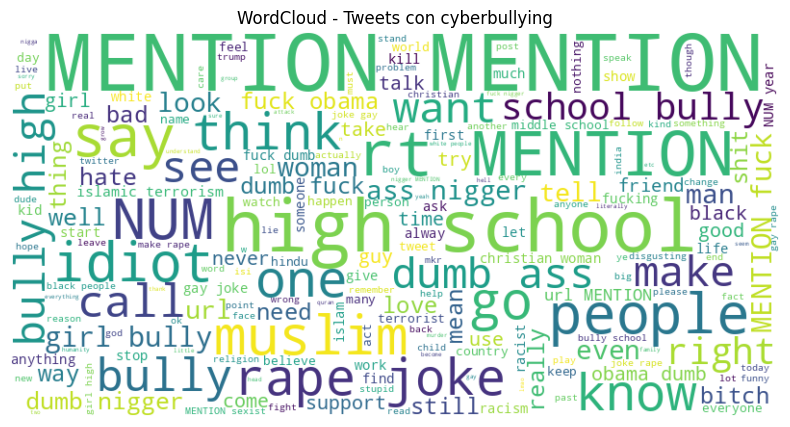

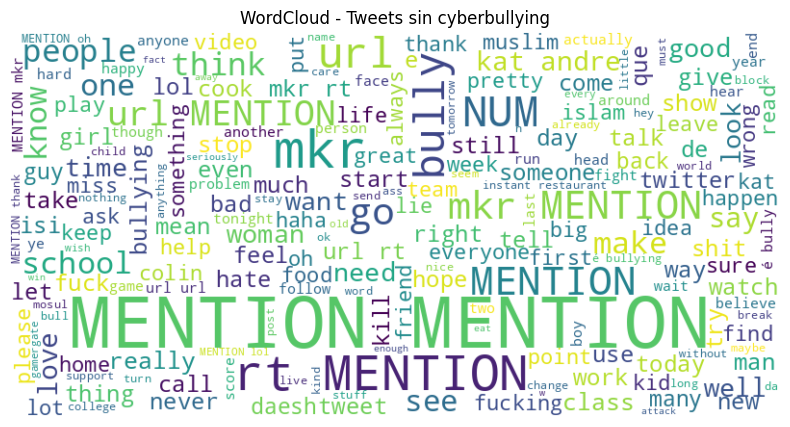

In [ ]:
# WordCloud para tweets con cyberbullying
hate_speech = ' '.join(dataset[dataset['cyberbullying'] == 1]['preprocessed_text'])
wordcloud_hate = WordCloud(width=800, height=400, background_color='white').generate(hate_speech)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_hate, interpolation='bilinear')
plt.title('WordCloud - Tweets con cyberbullying')
plt.axis('off')
plt.show()

# WordCloud para tweets sin cyberbullying
non_hate_speech = ' '.join(dataset[dataset['cyberbullying'] == 0]['preprocessed_text'])
wordcloud_non_hate = WordCloud(width=800, height=400, background_color='white').generate(non_hate_speech)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_hate, interpolation='bilinear')
plt.title('WordCloud - Tweets sin cyberbullying')
plt.axis('off')
plt.show()

Dado que las menciones las hemos sustituido por la palabra "mention", parece ser que en ambos tipos de tweets es común dirigirse directamente a un usuario.

Igual que en el Ejercicio 1, después del preprocesado las palabras que más predominan en los tweets con cyberbullying siguen siendo palabras como "muslim", "high school", "idiot" o "rape". En cambio, en los tweets sin cyberbullying parece que ninguna palabra llega a sobresalir demasiado (fijándonos en el tamaño), excepto "mkr", "rt" o "bully".

## 4. Vectorización

Empezaremos extrayendo los textos de los tweets como un array de cadenas y las etiquetas (0 o 1) como un array de enteros.

In [ ]:
texts = dataset.tweet_text.values
labels = dataset.cyberbullying.values

Dividimos los datos en conjuntos de entrenamiento y prueba. En este caso usaremos una partición 75-25 en lugar de 80-20. Luego, dividiremos el conjunto de entrenamiento en entrenamiento y validación, usando un 20% para validación.

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=.25, random_state=123,
                                                    stratify = labels)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=0,stratify = train_labels)

A continuación, cargaremos el tokenizer y el modelo preentrenado de DistilBERT. Para ello, definiremos un dataset personalizado para usar con el modelo.

In [ ]:
# Cargar el tokenizer y el modelo preentrenado
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Definición del Dataset personalizado
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts  # Textos del dataset
        self.labels = labels  # Etiquetas
        self.tokenizer = tokenizer  # Tokenizer para convertir texto en tokens
        self.max_length = max_length  # Longitud máxima para la tokenización

    def __len__(self):
        return len(self.texts)  # Retorna el tamaño del dataset

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Obtiene el texto en el índice dado
        label = int(self.labels[idx])  # Obtiene la etiqueta en el índice dado

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,  # Añade tokens especiales (CLS, SEP)
            max_length=self.max_length,  # Limita la longitud del texto
            truncation=True,  # Trunca el texto si es necesario
            padding='max_length',  # Rellena el texto hasta la longitud máxima
            return_tensors='pt'  # Retorna tensores PyTorch
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),  # IDs de los tokens
            'attention_mask': encoding['attention_mask'].flatten(),  # Máscara de atención
            'labels': torch.tensor(label, dtype=torch.long)  # Etiquetas
        }

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Transformamos nuestros datos al modelo DataSet.

In [ ]:
# Definimos la longitud máxima para el padding de los textos
max_length = 128

# Creamos los datasets personalizados para entrenamiento, validación y prueba
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)

Vamos verificar la muestra del dataset personalizado para asegurarnos de que todo esté correcto:

In [ ]:
train_dataset[20]

{'input_ids': tensor([ 101, 2821, 2085, 2027, 2081, 1037, 8257, 2055, 5637, 9040, 1999, 3827,
         1012, 2008, 1005, 1055, 2196, 2042, 2589, 2077, 1012,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0

## 5. Entrenamiento y evaluación de modelos


Usaremos el modelo preentrenado DistilBERT y lo ajustaremos a nuestro dataset.

In [ ]:
# Configuración del modelo para clasificación de secuencias
id2label = {0: "NO_CYBERBULLYING", 1: "CYBERBULLYING"}
label2id = {"NO_CYBERBULLYING": 0, "CYBERBULLYING": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

# Configuración de los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="modelo_test",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False
)

# Cargamos las métricas de evaluación
accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

# Definimos una función para calcular las métricas
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)

    return {
        "accuracy": accuracy_value['accuracy'],
        "f1_score": f1_score_value['f1']
    }

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ahora, crearemos un objeto Trainer para manejar el entrenamiento.

In [ ]:
# Creamos el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
# Entrenamos el modelo
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.262000,0.284557,0.881605,0.929446
2,0.238400,0.329373,0.892228,0.937107
3,0.170600,0.393116,0.887476,0.934387
4,0.152200,0.480951,0.883422,0.931482


TrainOutput(global_step=14308, training_loss=0.20990155187771578, metrics={'train_runtime': 1681.6202, 'train_samples_per_second': 68.065, 'train_steps_per_second': 8.508, 'total_flos': 3790554612541440.0, 'train_loss': 0.20990155187771578, 'epoch': 4.0})

  * Podemos ver cómo **Training Loss** va disminuyendo, lo que indica que el modelo está aprendiendo y ajustándose al conjunto de entrenamiento.
  * **Validation Loss** también disminuye inicialmente, pero luego comienza a aumentar, lo que podría ser un signo de sobreajuste (overfitting).
  * **Accuracy y F1-Score** en la validación son altos pero muestran cierta variabilidad, lo que podría indicar que el modelo está rindiendo bien en términos generales, pero la validación puede estar mostrando cierta inestabilidad.

In [ ]:
# Evaluamos el modelo en el conjunto de prueba
eval_results = trainer.evaluate(test_dataset)
print(eval_results)

# Realizamos predicciones en el conjunto de prueba
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = np.array([x['labels'].item() for x in test_dataset])

# Imprimimos la matriz de confusión y el reporte de clasificación
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

{'eval_loss': 0.27575916051864624, 'eval_accuracy': 0.8842573177891471, 'eval_f1_score': 0.9308201323440947, 'eval_runtime': 53.3836, 'eval_samples_per_second': 223.346, 'eval_steps_per_second': 27.93, 'epoch': 4.0}
[[1259  727]
 [ 653 9284]]
              precision    recall  f1-score   support

           0       0.66      0.63      0.65      1986
           1       0.93      0.93      0.93      9937

    accuracy                           0.88     11923
   macro avg       0.79      0.78      0.79     11923
weighted avg       0.88      0.88      0.88     11923



El modelo parece ser **más preciso para identificar tweets con cyberbullying** (clase 1) que aquellos sin cyberbullying (clase 0). Esto lo podemos ver en su precisión (0.93) y el 0.93 de recall.

Es decir, el modelo parece estar funcionando muy bien para detectar cyberbullying, pero deberían aplicarse ciertos cambios (tal vez en el preprocesado o incluso en la creación del modelo) para mejorar su detección de casos sin cyberbullying, como lo indica el bajo recall para la Clase 0.

**Comparación de modelos**

Por último, vamos a comparar nuestro modelo con el modelo elegido en el Ejercicio 1: **Random Forest con TF-IDF**.

Recordemos los resultados obtenidos del anterior modelo:

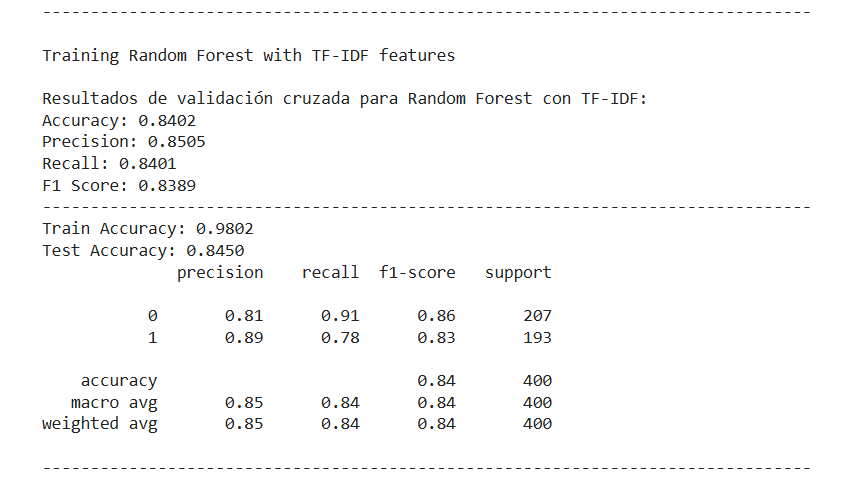

Con respecto a los resultados de evaluación, podemos ver que **DistilBERT tiene una mejor precisión general en el conjunto de prueba** (88.4% frente a 84.5%).

Además, la precisión de DistilBERT para la clase 1 (cyberbullying) es mayor que la de Random Forest (aunque tiene una menor precisión para la clase 0). De hecho, si nos fijamos en el promedio ponderado, DistilBERT también se muestra ligeramente mejor (0.88 frente a 0.85).

También, nuestro modelo de este Ejercicio 2 presenta un mejor recall para la clase 1, lo cual es crucial para detectar correctamente los casos de cyberbullying. Sin embargo, **Random Forest tiene un mejor recall en la clase 0**.

Por último, fijándonos en el F1-Score, DistilBERT sigue presentando mejores resultados, tanto en el F1-Score general (especialmente en la clase 1) como en el F1-Score ponderado.

A continuación, vamos a visualizar el modelo sobre un **gráfico de curva ROC y de precisión** para terminar de comparar sus resultados con nuestro anterior Random Forest del Ejercicio 1. Para ello, primero debemos realizar predicciones y calcular las probabilidades para el modelo de DistilBERT en el conjunto de prueba:

In [ ]:
# Obtenemos las probabilidades de predicción
pred_probs = trainer.predict(test_dataset).predictions
y_pred_proba_distilbert = torch.nn.Softmax(dim=1)(torch.tensor(pred_probs))[:, 1].numpy()

# Etiquetas
y_true_distilbert = np.array([x['labels'].item() for x in test_dataset])

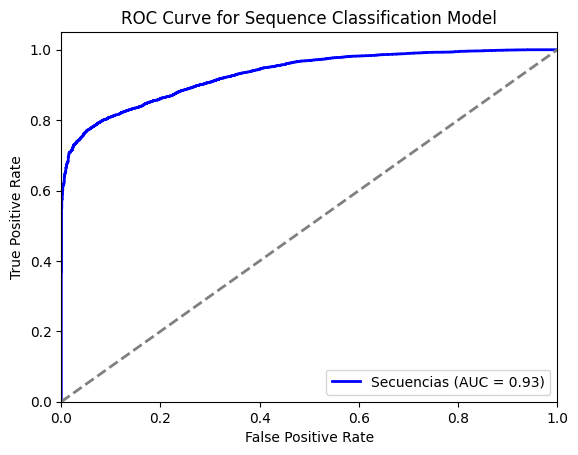

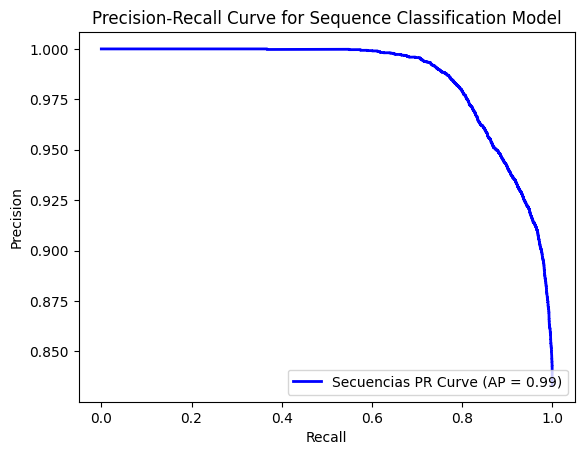

In [ ]:
# Calculamos la curva ROC
fpr_seq, tpr_seq, _ = roc_curve(y_true_distilbert, y_pred_proba_distilbert)
roc_auc_seq = auc(fpr_seq, tpr_seq)

# Calculamos la curva Precision-Recall
precision_seq, recall_seq, _ = precision_recall_curve(y_true_distilbert, y_pred_proba_distilbert)
average_precision_seq = average_precision_score(y_true_distilbert, y_pred_proba_distilbert)

# Graficamos
plt.figure()
plt.plot(fpr_seq, tpr_seq, color='blue', lw=2, label='Secuencias (AUC = %0.2f)' % roc_auc_seq)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sequence Classification Model')
plt.legend(loc='lower right')
plt.show()

# Graficar la curva Precision-Recall
plt.figure()
plt.plot(recall_seq, precision_seq, color='blue', lw=2, label='Secuencias PR Curve (AP = %0.2f)' % average_precision_seq)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Sequence Classification Model')
plt.legend(loc='lower right')
plt.show()

Recordemos los gráficos de Random Forest:

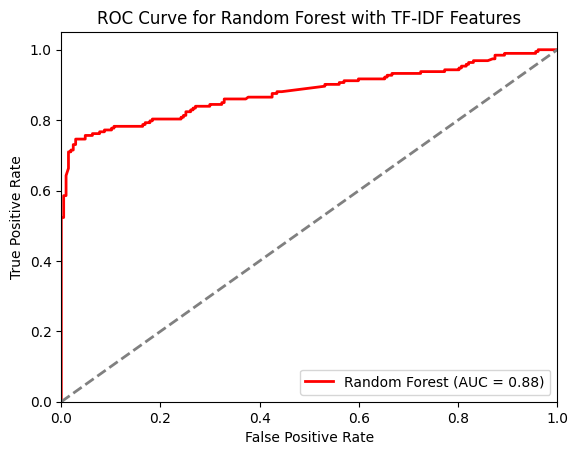

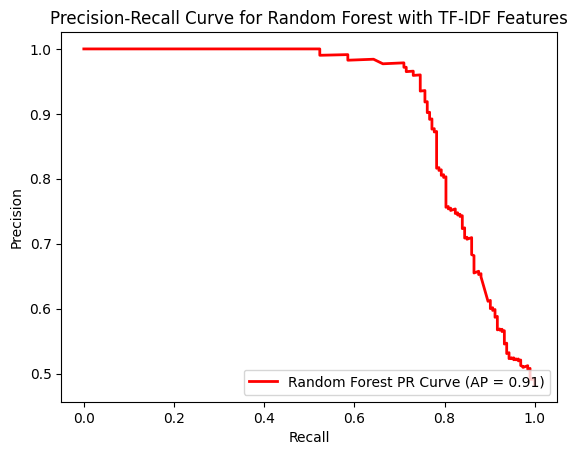

Podemos ver cómo nuestro modelo de este ejercicio presenta un rendimiento superior con una AUC más alta (0.93 vs. 0.88), lo que significa que en términos de clasificación general de las clases positivas y negativas, **DistilBERT realiza una mejor distinción que Random Forest**.

También muestra un AP notablemente más alto que el modelo del Ejercicio 1 (0.99 frente a 0.91), lo que indica que tiene un **mejor equilibrio entre la precisión y el recall que Random Forest**, especialmente en situaciones donde el modelo cuenta con un conjunto de datos desequilibrado o donde las clases positivas son menos frecuentes.

Finalmente, podemos concluir que **DistilBERT se muestra superior en métricas clave**, tanto en nuestros resultados de evaluación como en los gráficos que acabamos de analizar.

Muestra un rendimiento significativamente mejor en la detección de la clase 1 (cyberbullying), con un mayor F1-Score, precisión y recall.

Si bien Random Forest con TF-IDF tiene un mejor rendimiento en la detección de la clase 0 (no cyberbullying), como nuestro objetivo principal es detectar casos de cyberbullying, **DistilBERT parece ser la mejor opción**.